In [44]:
# Libraries imports
import numpy as np
import matplotlib.pyplot as plt
import cv2, skimage, os, sys
from collections import deque

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# Local imports
from src import saliancy_map as sm
from src import utils
from src import optimization as opt
from src import database as db
from manippulating_saliency_main import phi, update_taus, manipulate_saliency

print('Model loaded.')

Model loaded.


# Initialisation

In [46]:
# User Input
#image_path = './data/debug/easy_apple_small.jpg'
#mask_path = './data/debug/easy_apple_small_mask.jpg'
image_path = './data/object_enhancement/091_in.jpg'
mask_path = './data/object_enhancement/masks/091_mask.jpg'
desired_output_image_path = './data/object_enhancement/091_out.jpg'

delta_s = 0.8

# Constants
EPSILON = 1e-3

# Modular Definitions
compute_saliency_map = sm.tempsal_saliency
minimize_J = opt.minimize_J_global_poisson
compute_database = db.compute_location_database


Image size: (342, 512, 3)
Mask size: (171, 256)


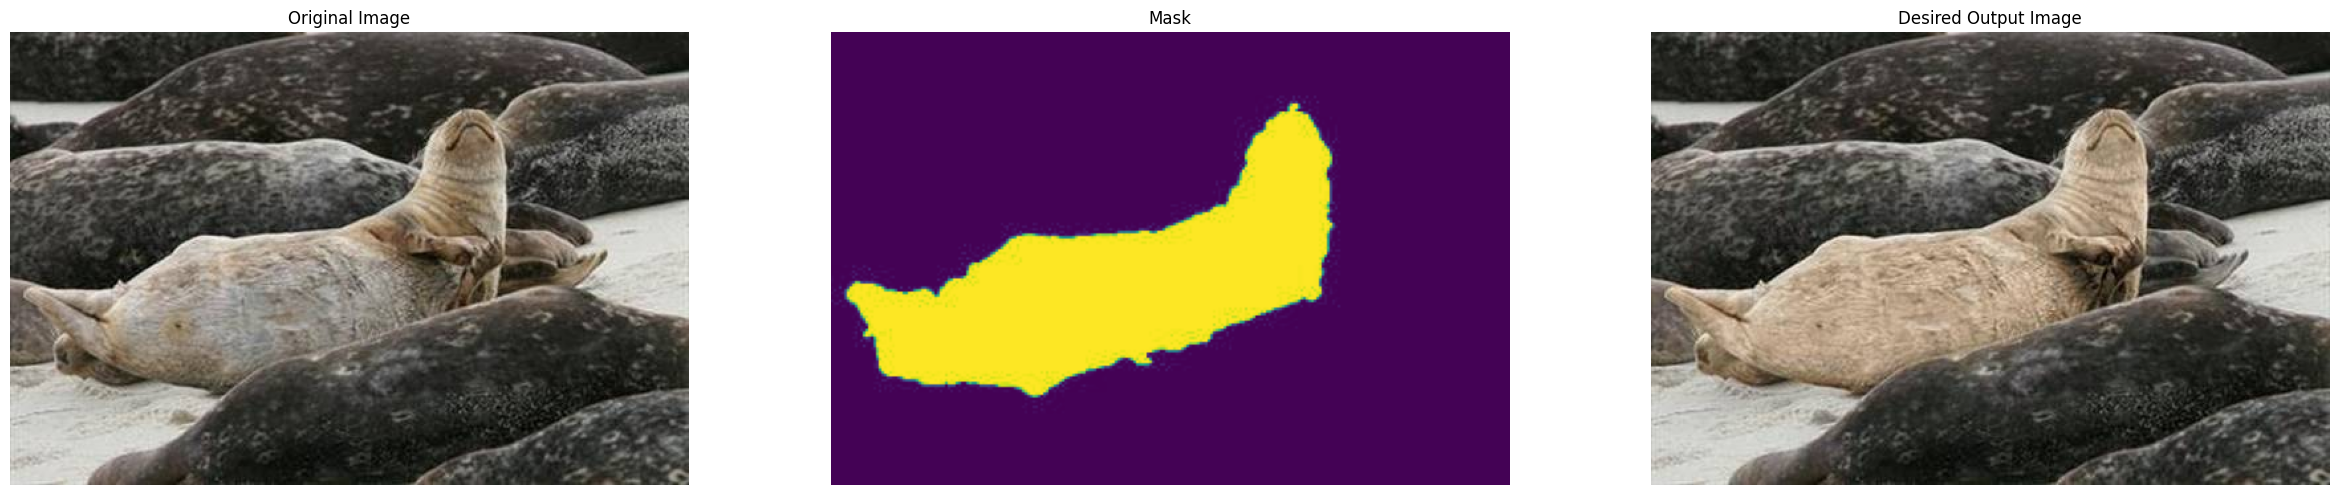

In [47]:
# Read the image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Image size:", img.shape)

mask_image = cv2.imread(mask_path)
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)[:,:]
print("Mask size:", mask_image.shape)

#show desired output image
desired_output_image = cv2.imread(desired_output_image_path)
desired_output_image = cv2.cvtColor(desired_output_image, cv2.COLOR_BGR2RGB)




utils.display_images([img, mask_image,desired_output_image], titles=['Original Image', 'Mask','Desired Output Image'])

In [48]:


mask_image_resized = cv2.resize(mask_image, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
assert img.shape[:2] == mask_image_resized.shape[:2], "Image and mask must match in size"

_, mask_image_resized = cv2.threshold(mask_image_resized, 127, 255, cv2.THRESH_BINARY)




# Saliency Manipulation

In [49]:
# Initialize tau +/-
tau_positive = 0.2
tau_negative = 0.05
prev_tau_positive = tau_positive
prev_tau_negative = tau_negative

J_in = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
J_out = np.array([])

#### Partial Algorithm

You must do the iteration yourself :) 

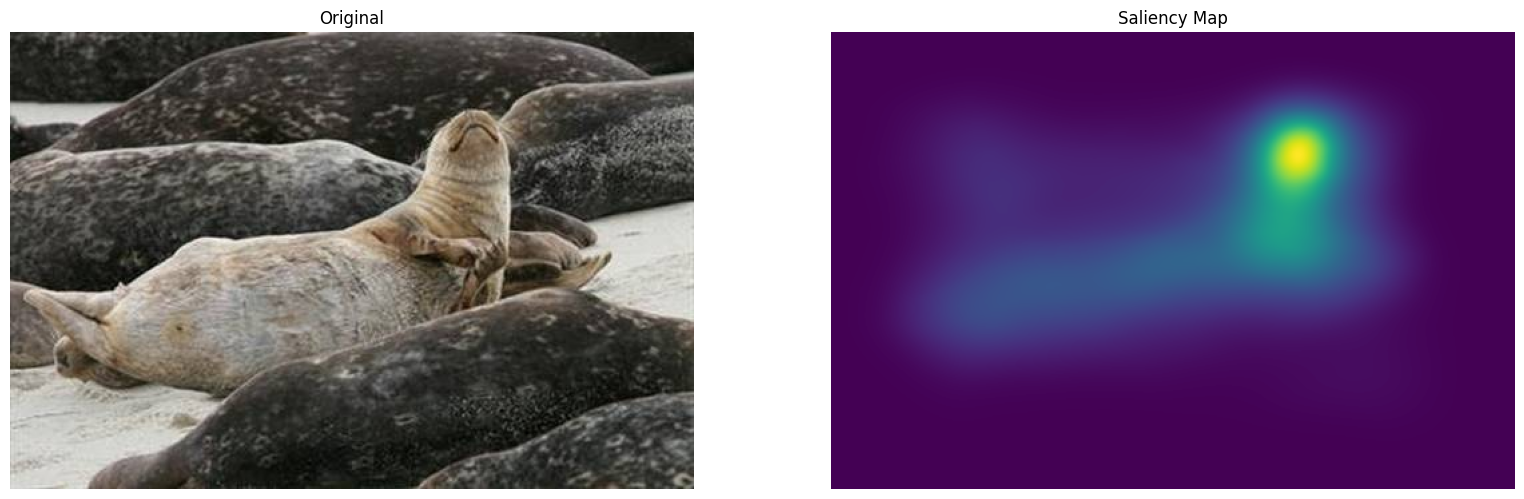

In [50]:
# Compute Saliency
s_map = compute_saliency_map(J_in)

utils.display_images([img, s_map], ['Original', 'Saliency Map'])

assert s_map.shape[:2] == mask_image_resized.shape

DB+ size: 25390, DB- size: 109644


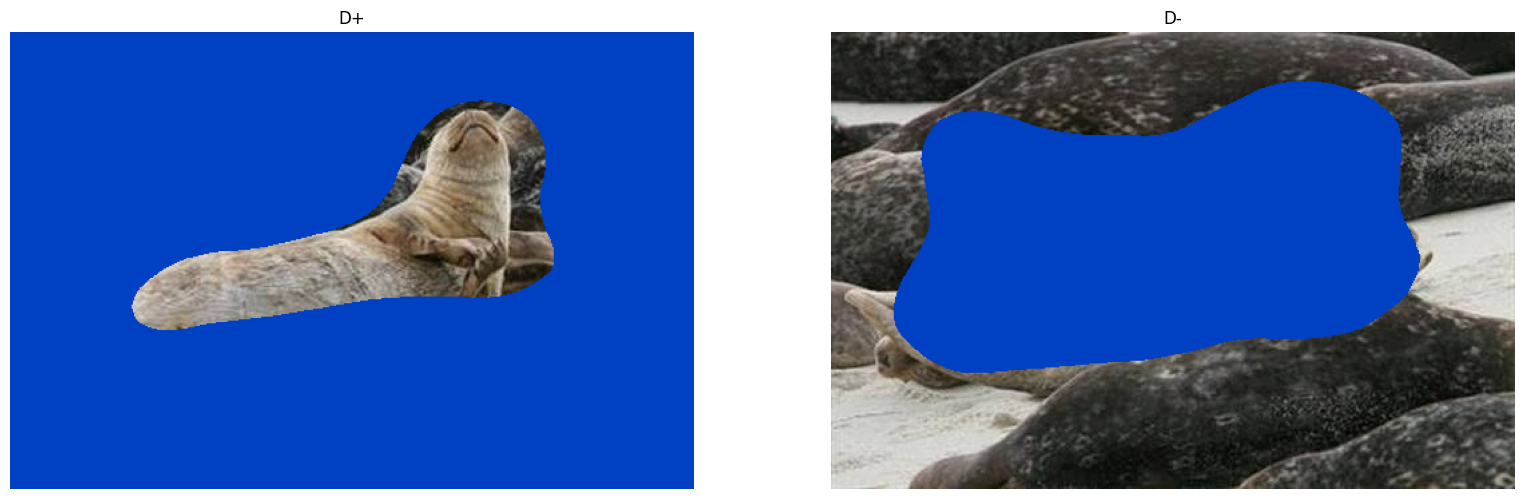

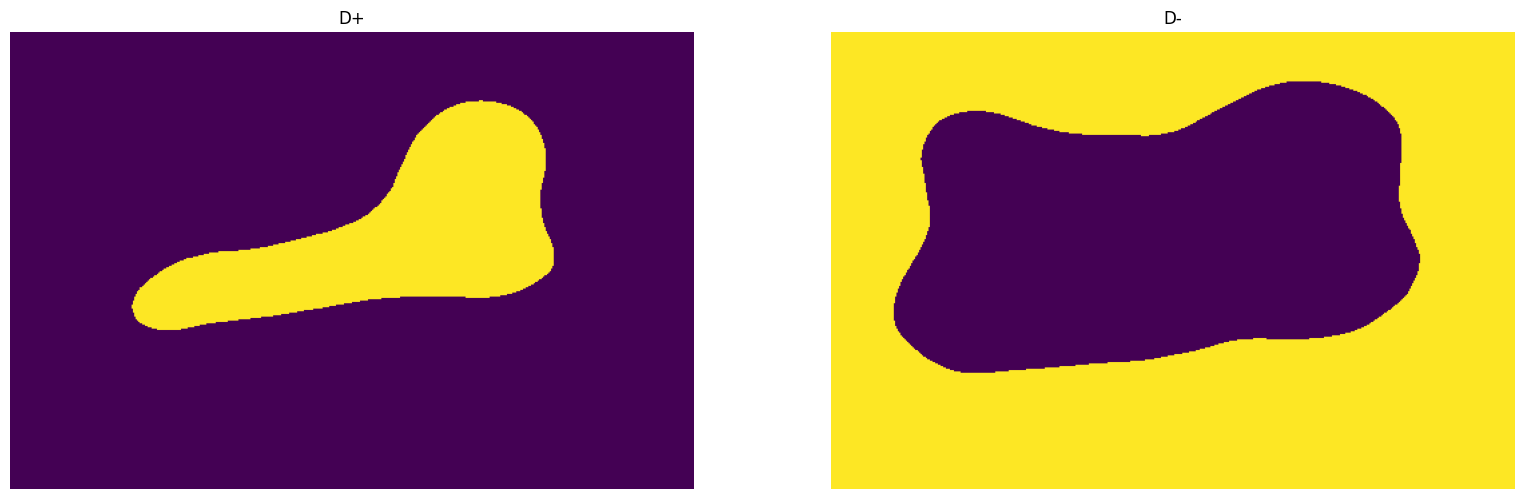

In [51]:
# DB update
D_positive, D_negative, d_pos_mask, d_neg_mask= compute_database(tau_positive, tau_negative, J_in, s_map)
print(f"DB+ size: {D_positive.shape[0]}, DB- size: {D_negative.shape[0]}")

# Construct and display the database's images
I_D_positive, I_D_negative = db.compute_image_database(J_in, D_positive, D_negative)

utils.display_images([I_D_positive, I_D_negative], ['D+', 'D-'])
utils.display_images([d_pos_mask, d_neg_mask], ['D+', 'D-'])

Search-and-vote

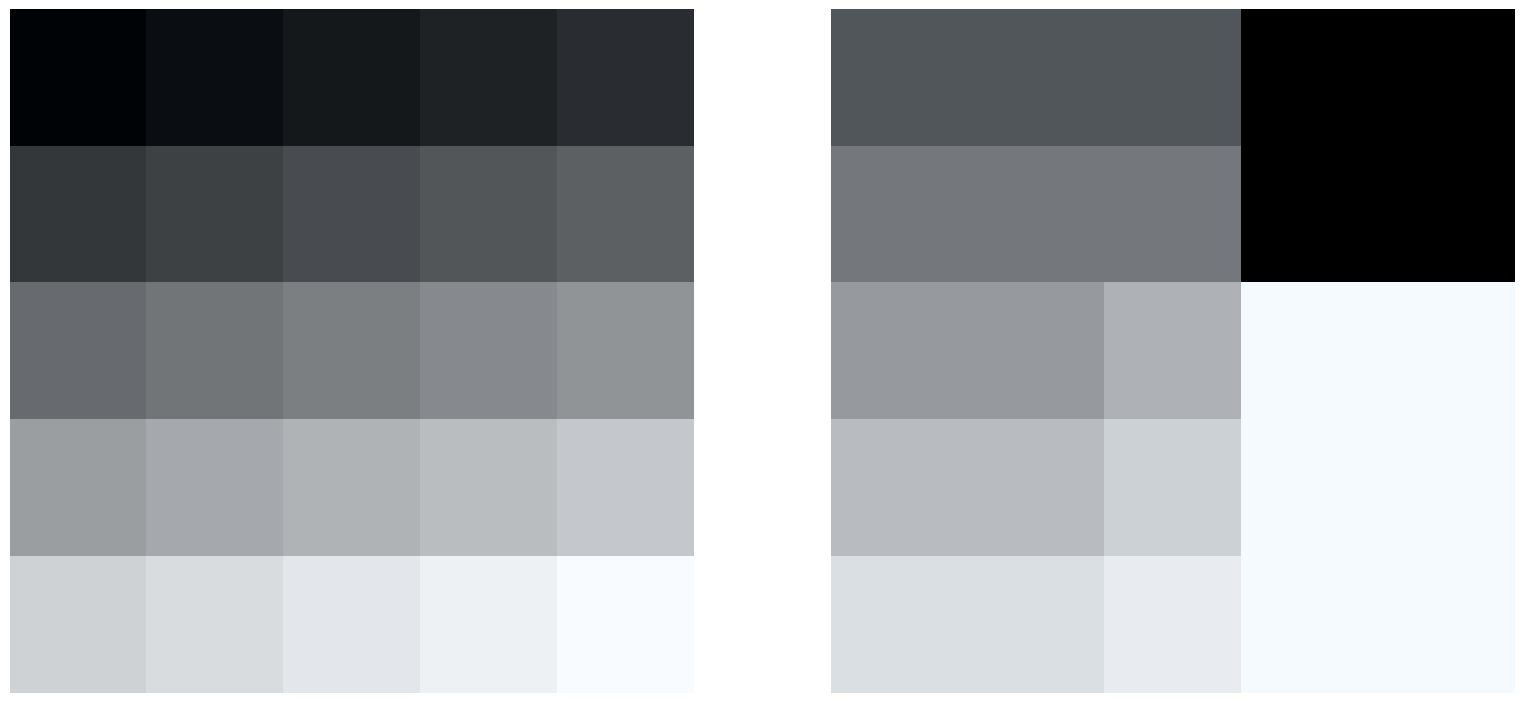

In [52]:
a = np.arange(75).reshape((5,5,3)) / 74
searched_patches_map = np.zeros((5,5,4))
patch_size=5
p_idxs = np.indices((3,3)).reshape(2, -1).T -1
for x in range(1,a.shape[0]-1, 2):
    for y in range(1, a.shape[1]-1, 2):
        x = np.random.randint(1,a.shape[0]-1)
        y = np.random.randint(1,a.shape[1]-1)
        p = a[x-1:x+2, y-1:y+2]
        s = searched_patches_map[x-1:x+2, y-1:y+2]

        # new_mean (per pixel) = temp_mean * N/(N+p*p) + p_mean / N+p*p
        n_plus_p2 = (s[:,:,3] + patch_size**2)
        s[:,:,:-1] *= (s[:,:,3] / n_plus_p2)[:,:,None]
        s[:,:,:-1] += np.ones_like(p) * p.sum(axis=(0,1)) / n_plus_p2[:,:,None]
        s[:,:,-1] = n_plus_p2.copy()
        

b = searched_patches_map[:,:,0:3]
b /= b.max()
utils.display_images([a,b])

Recursive patchy


In [53]:
from optimization import minimize_J_global_poisson_bfs


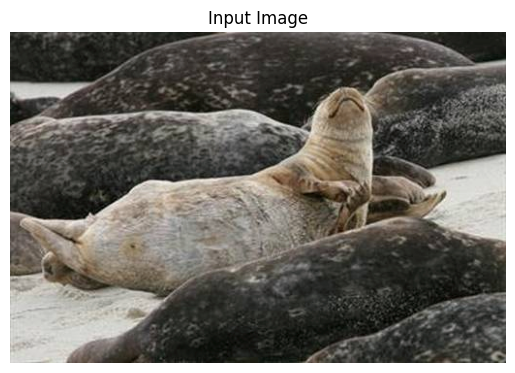

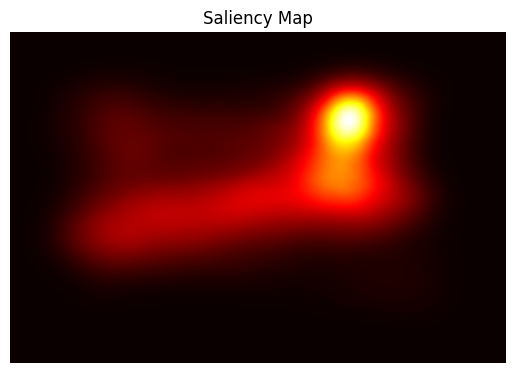

  - Padding image...
  - Generating offset field...
  - Search step...


100%|██████████| 50/50 [00:14<00:00,  3.37it/s]


  - BFS PatchMatch voting...
  - Merging layers...
  - Fixing borders before Poisson blending...
  - Overwriting full border region to suppress color halo...
  - Screened Poisson blending...
  - Finalizing result...


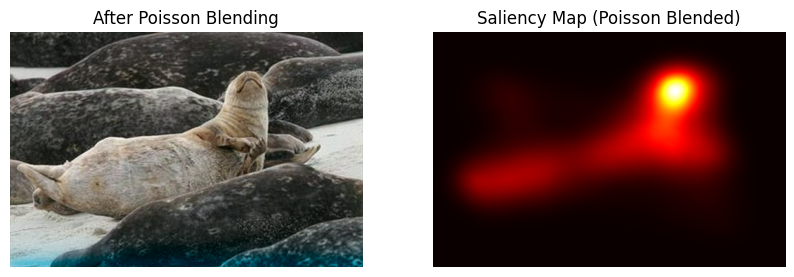

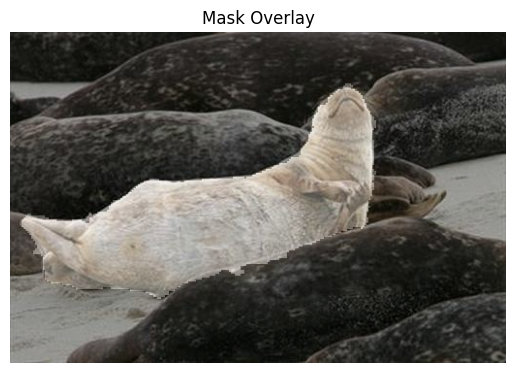

In [54]:
# Parameters
PATCH_SIZE = 7
MAX_DEPTH = 999

# Convert input image to Lab
J_in = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

# Show input
plt.imshow(cv2.cvtColor(J_in, cv2.COLOR_Lab2RGB))
plt.title("Input Image")
plt.axis("off")
plt.show()

#show input saliency map
s_map = compute_saliency_map(J_in)
plt.imshow(s_map, cmap="hot")
plt.title("Saliency Map")
plt.axis("off")
plt.show()

# Apply new recursive BFS PatchMatch with layered voting
J_lab_result, vote_weights = minimize_J_global_poisson_bfs(
    J_in,
    mask_image_resized,
    D_positive,
    D_negative,
    d_pos_mask,
    d_neg_mask,
    patch_size=PATCH_SIZE,
    lambda_factor=0.005
)

# Convert to RGB for display
J_rgb = cv2.cvtColor(J_lab_result, cv2.COLOR_Lab2RGB)

# === Display ===


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(J_rgb)
plt.title("After Poisson Blending")
plt.axis("off")

plt.subplot(1, 2, 2)
s_map = compute_saliency_map(J_rgb)
plt.imshow(s_map, cmap="hot")
plt.title("Saliency Map (Poisson Blended)")
plt.axis("off")
plt.show()

# Overlay mask on original
plt.imshow(img)
plt.imshow(mask_image_resized, alpha=0.3, cmap='gray')
plt.title("Mask Overlay")
plt.axis("off")
plt.show()




In [ ]:
# === RUN BLOCK for Multiple Iterations with BFS Recursive PatchMatch (New Version) ===
PATCH_SIZE = 7
MAX_DEPTH = 999
run_times = 5

# Initialization
tau_positive = 0.3
tau_negative = 0.3
learning_rate_positive = 0.1
learning_rate_negative = 0.1
delta_s = 0.8

# Convert input image to Lab space
J_in = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
s_map = compute_saliency_map(J_in)

for i in range(run_times):
    print(f"\n--- Iteration {i+1} ---")

    # Compute D+ and D- databases and masks
    D_positive, D_negative, d_pos_mask, d_neg_mask = compute_database(
        tau_positive, tau_negative, J_in, s_map
    )

    # Run BFS Recursive PatchMatch with Poisson & border handling
    J_lab_result, vote_weights = minimize_J_global_poisson_bfs(
        J_in,
        mask_image_resized,
        D_positive,
        D_negative,
        d_pos_mask,
        d_neg_mask,
        patch_size=PATCH_SIZE,
        lambda_factor=0.5
    )

    # Convert to RGB for display
    J_rgb = cv2.cvtColor(J_lab_result, cv2.COLOR_Lab2RGB)

    # Show result
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(J_rgb)
    plt.title(f'Patched Image - Iter {i+1}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(s_map, cmap='hot')
    plt.title(f'Saliency Map - Iter {i+1}')
    plt.axis('off')
    plt.show()

    # Show current D+ and D- database patch visualizations
    I_D_positive, I_D_negative = db.compute_image_database(J_in, D_positive, D_negative)
    utils.display_images([I_D_positive, I_D_negative], ['D+', 'D-'])

    # Prepare for next iteration
    J_in = cv2.cvtColor(J_rgb.astype(np.uint8), cv2.COLOR_RGB2Lab)
    s_map = compute_saliency_map(J_in)

    # Saliency feedback update
    assert s_map.shape[:2] == mask_image_resized.shape, "Mismatch between saliency map and mask."
    saliency_foreground = np.mean(s_map[mask_image_resized > 0])
    saliency_background = np.mean(s_map[mask_image_resized == 0])
    current_contrast = saliency_foreground - saliency_background

    print(f"Saliency Foreground: {saliency_foreground:.4f}, Saliency Background: {saliency_background:.4f}")
    print(f"Current contrast: {current_contrast:.4f}, Desired contrast: {delta_s:.4f}")

    # Update tau values
    adjustment_positive = np.abs(current_contrast - delta_s) * learning_rate_positive
    adjustment_negative = np.abs(current_contrast - delta_s) * learning_rate_negative
    tau_positive = np.clip(tau_positive + adjustment_positive, 0, 1)
    tau_negative = np.clip(tau_negative - adjustment_negative, 0, 1)

    print(f"Updated tau_positive: {tau_positive:.4f}, tau_negative: {tau_negative:.4f}")

# Final output comparison
utils.display_images([img, J_rgb, desired_output_image],
                     ['Original Image', 'Final Image', 'Desired Output Image'])

# Saliency map comparison
s_map_original = compute_saliency_map(cv2.cvtColor(img, cv2.COLOR_RGB2Lab))
s_map_final = compute_saliency_map(cv2.cvtColor(J_rgb, cv2.COLOR_RGB2Lab))
s_map_desired = compute_saliency_map(cv2.cvtColor(desired_output_image, cv2.COLOR_RGB2Lab))

utils.display_images([s_map_original, s_map_final, s_map_desired],
                     ['Original Image Saliency Map', 'Final Image Saliency Map', 'Desired Output Image Saliency Map'])



--- Iteration 1 ---


NameError: name 'compute_location_database' is not defined

In [110]:
# Compute saliency maps
sal_before = compute_saliency_map(img)
sal_after = compute_saliency_map(J_rgb)

# Compute mean saliency inside and outside mask
s_before_fg = np.mean(sal_before[mask_image > 0])
s_before_bg = np.mean(sal_before[mask_image == 0])
s_after_fg = np.mean(sal_after[mask_image > 0])
s_after_bg = np.mean(sal_after[mask_image == 0])

print("Before: ΔS =", round(s_before_fg - s_before_bg, 4))
print("After:  ΔS =", round(s_after_fg - s_after_bg, 4))

Before: ΔS = 0.267
After:  ΔS = 0.2787


Poisson Screening

In [31]:
poisson_padded = opt.screen_poisson(J_paded, J_patched_padded, lambda_factor=5.)

# un-pad the image
J_out = np.floor(poisson_padded[radius:width+radius, radius:height+radius]).astype(np.uint8)

error: OpenCV(4.11.0) D:/a/opencv-python/opencv-python/opencv/modules/imgproc/src/filter.simd.hpp:3252: error: (-213:The function/feature is not implemented) Unsupported combination of source format (=1), and destination format (=6) in function 'cv::opt_AVX2::getLinearFilter'


In [13]:
# Display Resutls
J_out_rgb = cv2.cvtColor(J_out, cv2.COLOR_Lab2RGB)
diff = np.abs(img - J_out_rgb).mean(axis=2) / 255
print(diff.min(), diff.max())
utils.display_images([img, J_out_rgb, diff], ['Original', 'Modified Saliency', 'diff'])


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


##### Poisson lambda factor test

In [15]:
poissons = []
lambdas = np.logspace(-5,0, 6) * 5

for l in lambdas:
    poisson_padded = opt.screen_poisson(J_paded, J_patched_padded, lambda_factor=l)

    # un-pad the image
    poissons.append(np.floor(poisson_padded[radius:-radius, radius:-radius]).astype(np.uint8))


error: OpenCV(4.11.0) D:/a/opencv-python/opencv-python/opencv/modules/imgproc/src/filter.simd.hpp:3252: error: (-213:The function/feature is not implemented) Unsupported combination of source format (=1), and destination format (=6) in function 'cv::opt_AVX2::getLinearFilter'


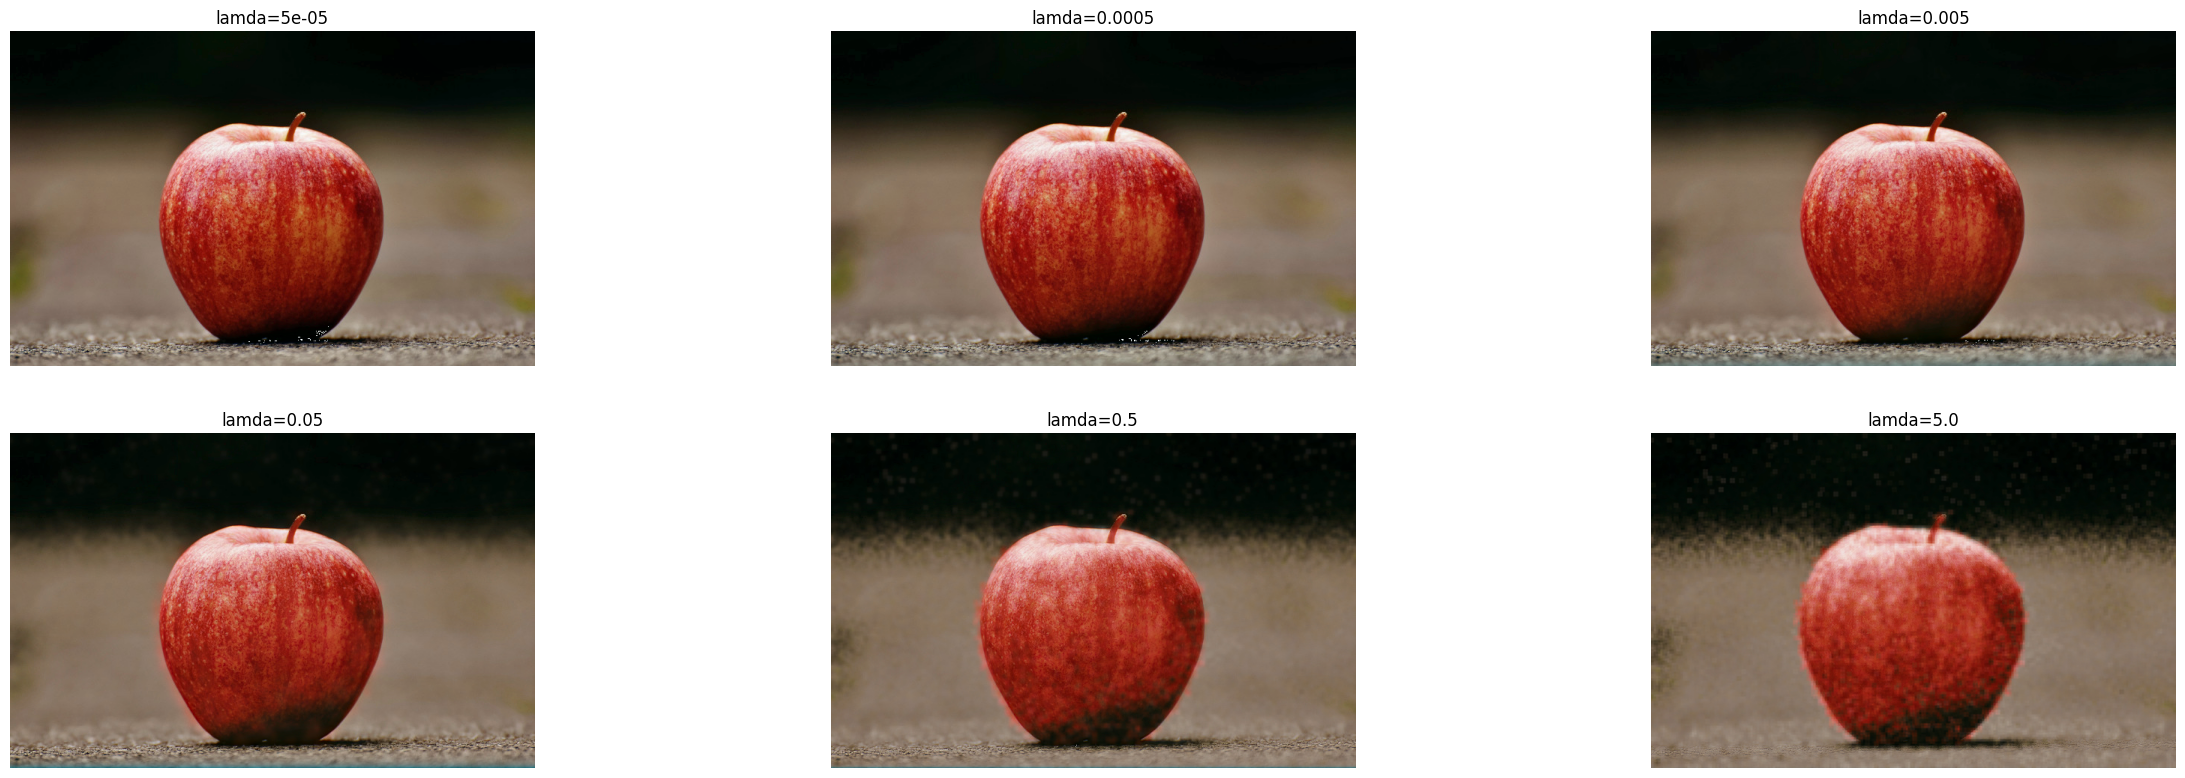

In [106]:
# Display results
utils.display_images([cv2.cvtColor(p, cv2.COLOR_Lab2RGB) for p in poissons], [f'lamda={l}' for l in lambdas])

(un-comment if you want to manualy iterate)

In [ ]:
# # switch the buffers
# temp = J_in.copy()
# J_in = J_out
# J_out = J_in

# # Update tau +/-
# tau_positive, tau_negative = update_taus(tau_positive, tau_negative, s_map, mask_image, delta_s)
# print(f'\n4Tau+: {tau_positive}, Tau-: {tau_negative}')


#### Full Algorithm

In [ ]:
nb_iterations = 1

print("Begin Saliency Manipulation:")

# while compute_criterion(S_J, R, delta_s) > EPSILON:
for x in  range(nb_iterations):
    print(f"Iteration {x}")
    # update the saliency map
    print(" - computing Saliency...")
    s_map = compute_saliency_map(J_in)
    print(" - Done.")

    # DB update
    print(" - computing DB...")
    D_positive, D_negative = compute_database(tau_positive, tau_negative, J_in, s_map)
    print(f" - Done, DB+ size: {D_positive.shape[0]}, DB- size: {D_negative.shape[0]}")
    
    # Construct and display the database's images
    I_D_positive, I_D_negative = db.compute_image_database(J_in, D_positive, D_negative)

    # utils.display_images([S_J, I_D_positive, I_D_negative])

    # update J to minimize the energy function
    print(" - Minimizing function...")
    J_out = minimize_J(J_in, mask_imask_image_resizedmage, D_positive, D_negative)
    print(" - Done.")
    # Update tau +/-
    tau_positive, tau_negative = update_taus(tau_positive, tau_negative, s_map, mask_imask_image_resizedmage, delta_s)

    # switch the buffers (only affect the references so no copy is made)
    temp = J_in.copy()
    J_in = J_out
    J_out = J_in

    # Check if convergence is reached by tau's
    tau_diff = abs(tau_positive - prev_tau_positive) + abs(tau_negative - prev_tau_negative)
    prev_tau_positive, prev_tau_negative = tau_positive, tau_negative
    if tau_diff < EPSILON:
        break

    # print("\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K", end="")
    
# Cancel the last input-output exchange
temp = J_in.copy()
J_in = J_out
J_out = J_in

print("Done")
J_out = cv2.cvtColor(J_out, cv2.COLOR_Lab2RGB)

Begin Saliency Manipulation:
Iteration 0
 - computing Saliency...
 - Done.
 - computing DB...
 - Done, DB+ size: 33469, DB- size: 215630
 - Minimizing function...
  - Applying PatchMatch...
  - Applying Poisson Screening... - Done.
Done


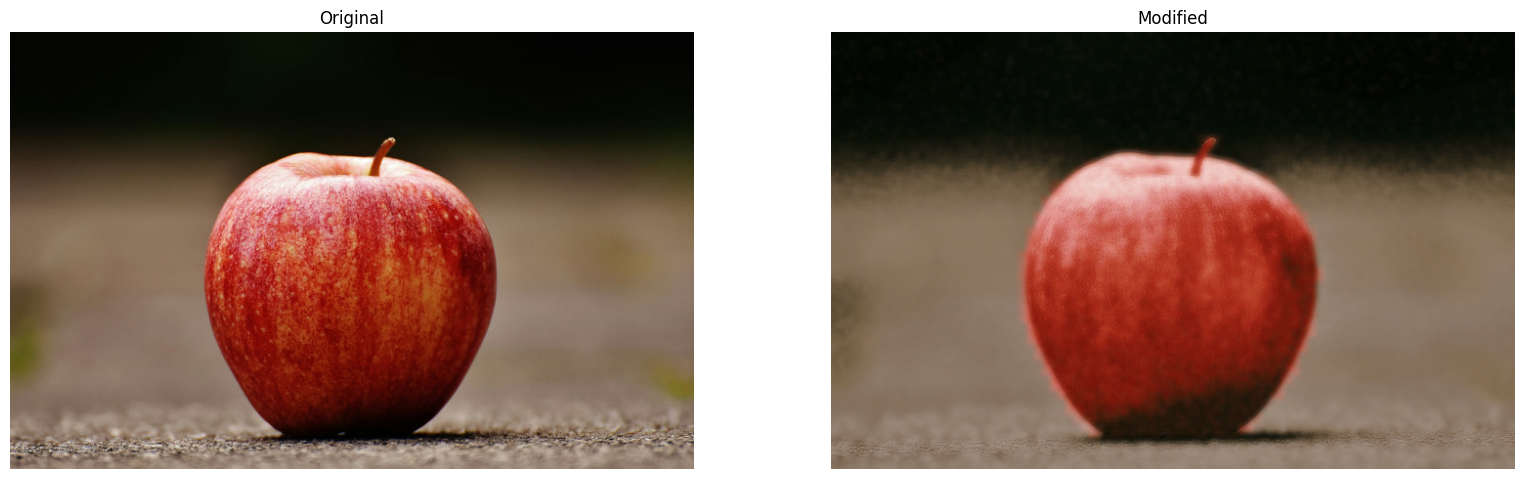

In [118]:
# Display results
utils.display_images([img, J_out], ['Original', 'Modified'])